In [1]:
import src
import imp
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

/opt/conda/lib/python3.7/site-packages/pvlib/solarposition.py:265: UserWarning: Reloading spa to use numba
  warnings.warn('Reloading spa to use numba')


In [51]:
import imp
imp.reload(src.features.transformers)

<module 'src.features.transformers' from '/home/davidjamesfulton93/repos/predict_pv_yield/src/features/transformers.py'>

In [2]:
pv_metadata_df = src.data.load_pv.load_pv_metadata("~/repos/predict_pv_yield/data/"+src.data.load_pv.PV_METADATA_FILEPATH)

In [3]:
pv_metadata_df.head()

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,...,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary,x,y
system_id,,,,,,,,,,,,,,,,,,,,,
690,3.8kw of Power @ No3,3800,NaN,20,190,Phono Solar,1,4000,SMA Sunny Boy 4000,S,...,2010-12-01 00:00:00,52.087171,-0.263414,10,0,0,NaN,NaN,519080.191006,244623.301288
709,Grove Cottages,2460,RG4,12,205,Romag PowerGlaz SMT6(54)P,1,3000,SMA Sunny Boy 3000TL,SE,...,2010-09-28 00:00:00,51.485329,-0.967526,5,0,0,NaN,NaN,471786.316866,176769.072244
777,Underfell1,3420,NaN,18,190,Schuco MPE 190 MS 05,1,4000,SMA Sunny Boy 4000TL,SW,...,2010-10-29 00:00:00,54.197863,-2.938757,10,0,0,NaN,NaN,338853.840270,478417.935178
794,Roofline,3700,GU34,20,185,Sharp,1,4000,SMA,SE,...,2011-01-05 00:00:00,51.112485,-1.032715,5,0,0,NaN,NaN,467806.490433,135244.187025
973,number38,4000,WA11,16,250,Sungrid/SG250M6,1,3800,Sunny Boy 3800,SW,...,2011-01-13 00:00:00,53.467927,-2.675806,5,0,0,NaN,NaN,355234.617987,397009.685712


In [4]:
pv_power_df = src.data.load_pv.load_pv_power(filepath="~/repos/predict_pv_yield/data/"+src.data.load_pv.PV_DATA_FILEPATH, start='2018-01-01', end='2019-12-31')

In [5]:
pv_power_df = pv_power_df.dropna(axis=0, how='all')

In [6]:
pv_power_df.head()

,690,709,794,973,1364,1556,1627,1646,1647,1872,...,68000,68212,68218,68219,68303,68324,68404,68443,68800,68846
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 03:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:35:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:50:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Drop systems (in-place) without PV data and metadata
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [8]:
# make clearsky GHI object
latitude, longitude = pv_metadata_df.loc[pv_power_df.columns, ['latitude', 'longitude']].values.T
ghiscalar = src.features.transformers.ClearskyScalar(latitude, longitude, g0=10)

# filter data to daylight hours (in-place)
ghiscalar.filter_to_daylight(pv_power_df, min_ghi=5, inplace=True)

In [9]:
# drop rows systems with no daylight
pv_power_df = pv_power_df.dropna(axis=0, how='all')
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [94]:
# scale by max power output
rminmax = src.features.transformers.RobustMinMaxScaler(saturation_fraction=0.01)
pv_prop_max_df = rminmax.fit_transform(pv_power_df)

In [53]:
ghi_df = pd.DataFrame(ghiscalar.haurwitz_ghi(pv_power_df.index), index=pv_power_df.index, columns=pv_power_df.columns)

In [103]:
rminmax_area = src.features.transformers.RobustMinMaxScaler(saturation_fraction=0.01)
pv_prop_max_area_df = rminmax_area.fit_transform(rminmax.inverse_transform(pv_prop_max_df)/ghi_df)

In [104]:
pv_prop_max_area_df

,690,709,794,973,1364,1556,1627,1646,1647,1872,...,68000,68212,68218,68219,68303,68324,68404,68443,68800,68846
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 08:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 08:25:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 08:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 08:35:00+00:00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 08:40:00+00:00,NaN,NaN,NaN,NaN,0.14684,0.0,0.231646,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-20 19:10:00+00:00,NaN,NaN,NaN,0.059439,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.253580,0.216189,0.040075,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-20 19:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.208371,0.255192,0.013099,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-20 19:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.171475,0.235526,0.384386,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# persistence
def measurement_persistence_mae_and_mse(timedelta):
    diff = pv_prop_max_df - (pv_prop_max_df.reindex(pv_prop_max_df.index-pd.Timedelta(timedelta))).values
    mse = (diff**2).mean().mean()
    mae = np.abs(diff).mean().mean()
    return mse, mae

In [56]:
measurement_persistence_mae_and_mse('5min')

(0.010094275795269362, 0.04296796706017755)

In [57]:
measurement_persistence_mae_and_mse('30min')

(0.027141073031252516, 0.10097961845366672)

In [101]:
measurement_persistence_mae_and_mse('60min')

(0.0417829165904039, 0.1405783062396576)

In [102]:
measurement_persistence_mae_and_mse('120min')

(0.07899827368784698, 0.2109078188494364)

In [105]:
def area_persistence_mae_and_mse(timedelta):
    diff = (pv_prop_max_df - 
            rminmax.transform(
                rminmax_area.inverse_transform(
                    pv_prop_max_area_df.reindex(pv_prop_max_area_df.index-pd.Timedelta(timedelta))
                ).values*ghi_df
            )
    )
    mse = (diff**2).mean().mean()
    mae = np.abs(diff).mean().mean()
    return mse, mae

In [106]:
area_persistence_mae_and_mse('5min')

(0.010013623381046395, 0.04292786300672035)

In [107]:
area_persistence_mae_and_mse('30min')

(0.024710984272074438, 0.089826089113504)

In [108]:
area_persistence_mae_and_mse('60min')

(0.033133349443997345, 0.11382232230337863)

In [111]:
timedeltas = pd.TimedeltaIndex([f'{n}min' for n in np.arange(0, 245, 5)])

In [115]:
%time measurement_presistence = [measurement_persistence_mae_and_mse(f'{n}min') for n in np.arange(0, 245, 5)]

CPU times: user 1min 37s, sys: 31.2 s, total: 2min 9s
Wall time: 52 s


In [116]:
%time area_presistence = [area_persistence_mae_and_mse(f'{n}min') for n in np.arange(0, 245, 5)]

CPU times: user 8min 24s, sys: 1min 59s, total: 10min 23s
Wall time: 7min 24s


In [117]:
mse_measurement_presistence = [x[0] for x in measurement_presistence]
mae_measurement_presistence = [x[1] for x in measurement_presistence]

In [119]:
mse_area_presistence = [x[0] for x in area_presistence]
mae_area_presistence = [x[1] for x in area_presistence]

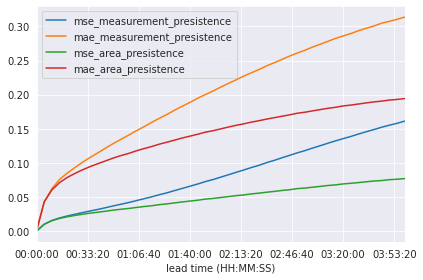

In [131]:
sns.set_style('darkgrid')
pd.DataFrame(
    dict(
        mse_measurement_presistence=mse_measurement_presistence,
        mae_measurement_presistence=mae_measurement_presistence,
        mse_area_presistence=mse_area_presistence,
        mae_area_presistence=mae_area_presistence
    ),
    index=timedeltas,).plot()
plt.xlabel('lead time (HH:MM:SS)')
plt.tight_layout()
plt.show()

In [135]:
def conv_output_size(H_in, kernel_size, padding, dilation, stride):
    return int((H_in+2*padding - dilation * (kernel_size-1)-1)/stride + 1)

x = 72
for _ in range(7):
    x = conv_output_size(x, 10, 0, 1,1)
    print(x)

63
54
45
36
27
18
9
